# Short Squeeze Protection Product Analysis

Complete analysis tool for hedge fund protection against market squeezes.

## 1. Setup & Imports

In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("Libraries loaded")

Libraries loaded


## 2. Function Definitions

In [12]:
# Data Loading
def load_ticker_data(ticker):
    """
    Load ticker data from local CSV file.
    """
    filename = f"data/{ticker.replace('.', '_')}.csv"
    df = pd.read_csv(filename, index_col=0, parse_dates=True)
    df['Returns'] = df['Close'].pct_change()
    print(f"Loaded {ticker}: {len(df)} days, Price range: ${df['Close'].min():.2f} - ${df['Close'].max():.2f}")
    return df

def load_metadata():
    """Load squeeze event metadata."""
    return pd.read_csv('data/metadata.csv', index_col=0)

# Volatility Calculation
def calculate_volatility(df, window=30):
    """
    Calculate rolling volatility (annualized).
    """
    log_returns = np.log(df['Close'] / df['Close'].shift(1))
    volatility = log_returns.rolling(window=window).std() * np.sqrt(252)
    return volatility.bfill()

# Black-Scholes Pricing
def black_scholes_call(S, K, T, r, sigma):
    """
    Calculate European call option price.
    """
    if T <= 0:
        return max(S - K, 0)
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    call = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call

def calculate_delta(S, K, T, r, sigma):
    """
    Calculate option delta.
    """
    if T <= 0:
        return 1.0 if S > K else 0.0
    
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    return norm.cdf(d1)

# Options Portfolio
def create_options_portfolio(initial_price, strikes, maturities, weights, volatility, risk_free_rate=0.05):
    """
    Create options portfolio with multiple strikes.
    """
    options = []
    total_price = 0
    
    for K, days, w in zip(strikes, maturities, weights):
        T = days / 365.0
        price = black_scholes_call(initial_price, K, T, risk_free_rate, volatility)
        
        options.append({
            'strike': K,
            'maturity_days': days,
            'maturity_years': T,
            'weight': w,
            'price': price,
            'weighted_price': price * w
        })
        
        total_price += price * w
    
    return {
        'options': options,
        'total_price_per_share': total_price,
        'initial_price': initial_price,
        'risk_free_rate': risk_free_rate
    }

# Simulation with Mark-to-Market Valuation
def simulate_protection(market_data, portfolio, num_shares, volatility, management_fee_rate=0.01, reserve_rate=0.02):
    """
    Simulate protection product performance with mark-to-market option valuation.
    """
    initial_price = portfolio['initial_price']
    r = portfolio['risk_free_rate']
    results = []
    
    for idx, (date, row) in enumerate(market_data.iterrows()):
        current_price = row['Close']
        days_elapsed = idx
        
        # Use time-varying volatility
        if isinstance(volatility, pd.Series):
            current_vol = volatility.loc[date]
        else:
            current_vol = volatility
        
        # Calculate mark-to-market value of options
        options_value = 0
        portfolio_delta = 0
        
        for opt in portfolio['options']:
            T_remaining = max(0, opt['maturity_years'] - days_elapsed / 365.0)
            
            if T_remaining > 0:
                # Mark-to-market using Black-Scholes
                opt_price = black_scholes_call(current_price, opt['strike'], T_remaining, r, current_vol)
                delta = calculate_delta(current_price, opt['strike'], T_remaining, r, current_vol)
            else:
                # Intrinsic value at expiry
                opt_price = max(0, current_price - opt['strike'])
                delta = 1.0 if current_price > opt['strike'] else 0.0
            
            options_value += opt_price * opt['weight'] * num_shares
            portfolio_delta += delta * opt['weight']
        
        # P&L calculations
        short_pnl = (initial_price - current_price) * num_shares
        options_cost = portfolio['total_price_per_share'] * num_shares
        options_pnl = options_value - options_cost
        protected_pnl = short_pnl + options_pnl
        
        unprotected_loss = -short_pnl
        protected_loss = -protected_pnl
        
        results.append({
            'date': date,
            'price': current_price,
            'volatility': current_vol,
            'short_pnl': short_pnl,
            'options_value': options_value,
            'options_pnl': options_pnl,
            'protected_pnl': protected_pnl,
            'unprotected_loss': unprotected_loss,
            'protected_loss': protected_loss,
            'savings': unprotected_loss - protected_loss,
            'delta': portfolio_delta
        })
    
    return pd.DataFrame(results).set_index('date')

# Cost Breakdown
def print_cost_breakdown(portfolio, num_shares, management_fee_rate=0.01, reserve_rate=0.02):
    """
    Print detailed cost breakdown.
    """
    notional = portfolio['initial_price'] * num_shares
    options_premium = portfolio['total_price_per_share'] * num_shares
    management_fee = management_fee_rate * notional
    reserve_contribution = reserve_rate * notional
    total_cost = options_premium + management_fee + reserve_contribution
    
    print("="*60)
    print("COST BREAKDOWN")
    print("="*60)
    print(f"Notional Value:         ${notional:,.2f}")
    print()
    print(f"Options Premium:        ${options_premium:,.2f}")
    print(f"Management Fee (1%):    ${management_fee:,.2f}")
    print(f"Reserve Fund (2%):      ${reserve_contribution:,.2f}")
    print("-"*60)
    print(f"TOTAL UPFRONT COST:     ${total_cost:,.2f}")
    print(f"As % of Notional:       {(total_cost / notional * 100):.2f}%")
    print("="*60)
    print()

# Enhanced Visualization
def plot_results(results, ticker_name):
    """
    Plot simulation results with volatility.
    """
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f'{ticker_name} - Protection Product Analysis', fontsize=14, fontweight='bold')
    
    # Stock Price
    ax1 = axes[0, 0]
    ax1.plot(results.index, results['price'], color='black', linewidth=2)
    ax1.set_title('Stock Price')
    ax1.set_ylabel('Price ($)')
    ax1.grid(True, alpha=0.3)
    
    # Losses Comparison
    ax2 = axes[0, 1]
    ax2.plot(results.index, results['unprotected_loss'], label='Unprotected', color='red', linewidth=2)
    ax2.plot(results.index, results['protected_loss'], label='Protected', color='green', linewidth=2)
    ax2.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax2.set_title('Losses Comparison')
    ax2.set_ylabel('Loss ($)')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    # Savings
    ax3 = axes[0, 2]
    ax3.plot(results.index, results['savings'], color='green', linewidth=2)
    ax3.fill_between(results.index, 0, results['savings'], alpha=0.3, color='green')
    ax3.axhline(y=0, color='black', linestyle='-', alpha=0.3)
    ax3.set_title('Savings from Protection')
    ax3.set_ylabel('Savings ($)')
    ax3.grid(True, alpha=0.3)
    
    # Portfolio Delta
    ax4 = axes[1, 0]
    ax4.plot(results.index, results['delta'], color='blue', linewidth=2)
    ax4.set_title('Portfolio Delta')
    ax4.set_ylabel('Delta')
    ax4.set_ylim([0, 1])
    ax4.grid(True, alpha=0.3)
    
    # Volatility
    ax5 = axes[1, 1]
    ax5.plot(results.index, results['volatility'], color='orange', linewidth=2)
    ax5.set_title('Realized Volatility (Annualized)')
    ax5.set_ylabel('Volatility')
    ax5.grid(True, alpha=0.3)
    
    # Options Value
    ax6 = axes[1, 2]
    ax6.plot(results.index, results['options_value'], color='purple', linewidth=2)
    ax6.set_title('Options Portfolio Value (Mark-to-Market)')
    ax6.set_ylabel('Value ($)')
    ax6.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

# Enhanced Summary
def print_summary(results, portfolio, num_shares):
    """
    Print performance summary with ROI.
    """
    max_unprotected = results['unprotected_loss'].max()
    max_protected = results['protected_loss'].max()
    total_savings = max_unprotected - max_protected
    
    # Calculate total cost
    notional = portfolio['initial_price'] * num_shares
    options_premium = portfolio['total_price_per_share'] * num_shares
    management_fee = 0.01 * notional
    reserve_contribution = 0.02 * notional
    total_cost = options_premium + management_fee + reserve_contribution
    
    roi = ((total_savings - total_cost) / total_cost) * 100 if total_cost > 0 else 0
    
    print("="*60)
    print("PERFORMANCE SUMMARY")
    print("="*60)
    print(f"Initial Price:          ${portfolio['initial_price']:.2f}")
    print(f"Final Price:            ${results['price'].iloc[-1]:.2f}")
    print(f"Price Change:           {(results['price'].iloc[-1] / portfolio['initial_price'] - 1):.2%}")
    print()
    print(f"Max Unprotected Loss:   ${max_unprotected:,.2f}")
    print(f"Max Protected Loss:     ${max_protected:,.2f}")
    print(f"Total Savings:          ${total_savings:,.2f}")
    print(f"Savings Rate:           {(total_savings / max_unprotected * 100):.1f}%")
    print()
    print(f"Total Cost:             ${total_cost:,.2f}")
    print(f"Cost as % of Notional:  {(total_cost / notional * 100):.2f}%")
    print(f"ROI:                    {roi:,.1f}%")
    print("="*60)

print("Functions defined")

Functions defined


---
# CASE STUDIES

## Case Study 1: GameStop (GME) - January 2021

Loaded GME: 60 days, Price range: $4.31 - $86.88

Volatility range: 269.04% - 595.86%
Average volatility: 512.91%

Short Position Setup:
  Initial Price: $4.31
  Shares Shorted: 500,000
  Notional: $2,156,250.00
  Initial Volatility: 559.33%

Options Portfolio:
  Option 1: Strike $10, 90d, Weight 35%, Price $3.27
  Option 2: Strike $20, 180d, Weight 40%, Price $3.88
  Option 3: Strike $40, 270d, Weight 25%, Price $4.12
COST BREAKDOWN
Notional Value:         $2,156,250.00

Options Premium:        $1,863,079.01
Management Fee (1%):    $21,562.50
Reserve Fund (2%):      $43,125.00
------------------------------------------------------------
TOTAL UPFRONT COST:     $1,927,766.51
As % of Notional:       89.40%

PERFORMANCE SUMMARY
Initial Price:          $4.31
Final Price:            $48.62
Price Change:           1027.30%

Max Unprotected Loss:   $41,282,501.22
Max Protected Loss:     $5,489,563.20
Total Savings:          $35,792,938.02
Savings Rate:           86.7%

Total Cost:           

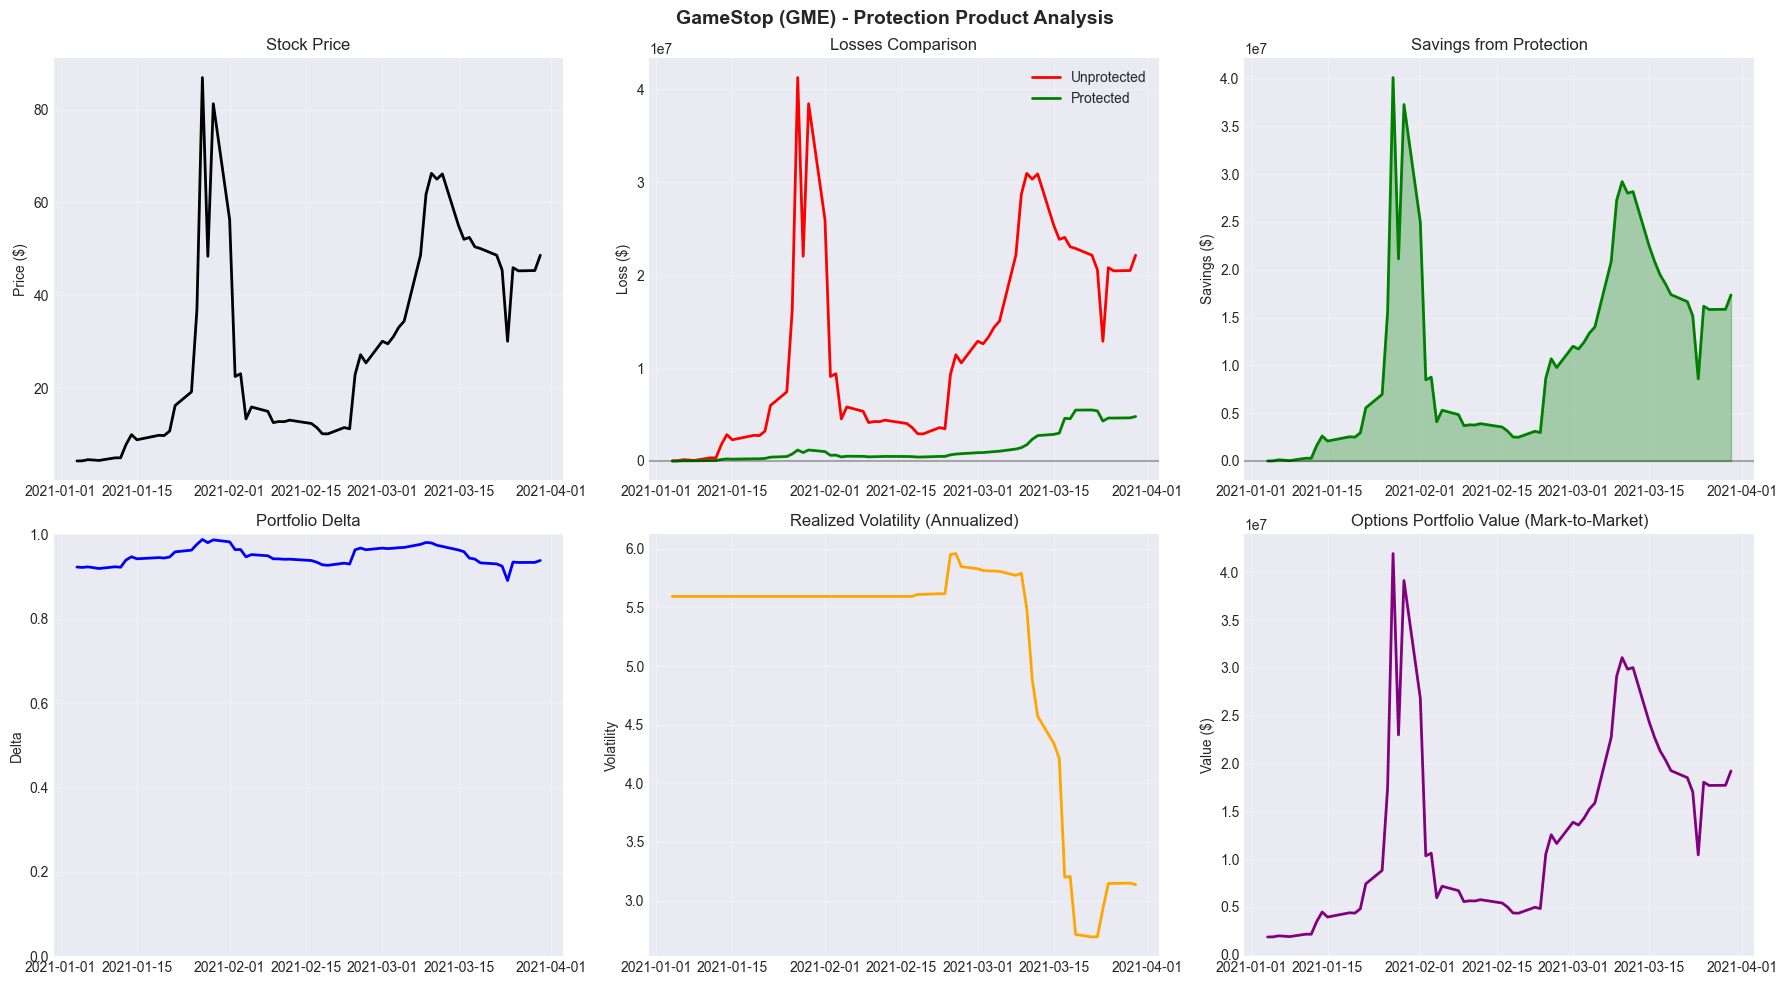

In [13]:
# Load data
gme_data = load_ticker_data('GME')
gme_data['Volatility'] = calculate_volatility(gme_data, window=30)

print(f"\nVolatility range: {gme_data['Volatility'].min():.2%} - {gme_data['Volatility'].max():.2%}")
print(f"Average volatility: {gme_data['Volatility'].mean():.2%}")

# Setup protection product
INITIAL_PRICE = gme_data['Close'].iloc[0]
NUM_SHARES = 500_000
AVG_VOL = gme_data['Volatility'].iloc[:10].mean()

print(f"\nShort Position Setup:")
print(f"  Initial Price: ${INITIAL_PRICE:.2f}")
print(f"  Shares Shorted: {NUM_SHARES:,}")
print(f"  Notional: ${INITIAL_PRICE * NUM_SHARES:,.2f}")
print(f"  Initial Volatility: {AVG_VOL:.2%}")

# Create portfolio
gme_portfolio = create_options_portfolio(
    initial_price=INITIAL_PRICE,
    strikes=[10, 20, 40],
    maturities=[90, 180, 270],
    weights=[0.35, 0.40, 0.25],
    volatility=AVG_VOL
)

print("\nOptions Portfolio:")
for i, opt in enumerate(gme_portfolio['options'], 1):
    print(f"  Option {i}: Strike ${opt['strike']}, {opt['maturity_days']}d, Weight {opt['weight']:.0%}, Price ${opt['price']:.2f}")

# Print detailed cost breakdown
print_cost_breakdown(gme_portfolio, NUM_SHARES)

# Run simulation with time-varying volatility
gme_results = simulate_protection(gme_data, gme_portfolio, NUM_SHARES, gme_data['Volatility'])

# Results
print_summary(gme_results, gme_portfolio, NUM_SHARES)
plot_results(gme_results, 'GameStop (GME)')

## Case Study 2: AMC Entertainment - June 2021

Loaded AMC: 63 days, Price range: $90.00 - $625.50
COST BREAKDOWN
Notional Value:         $48,549,999.24

Options Premium:        $38,865,434.81
Management Fee (1%):    $485,499.99
Reserve Fund (2%):      $970,999.98
------------------------------------------------------------
TOTAL UPFRONT COST:     $40,321,934.78
As % of Notional:       83.05%

PERFORMANCE SUMMARY
Initial Price:          $97.10
Final Price:            $370.20
Price Change:           281.26%

Max Unprotected Loss:   $264,200,000.76
Max Protected Loss:     $4,671,361.76
Total Savings:          $259,528,639.01
Savings Rate:           98.2%

Total Cost:             $40,321,934.78
Cost as % of Notional:  83.05%
ROI:                    543.6%


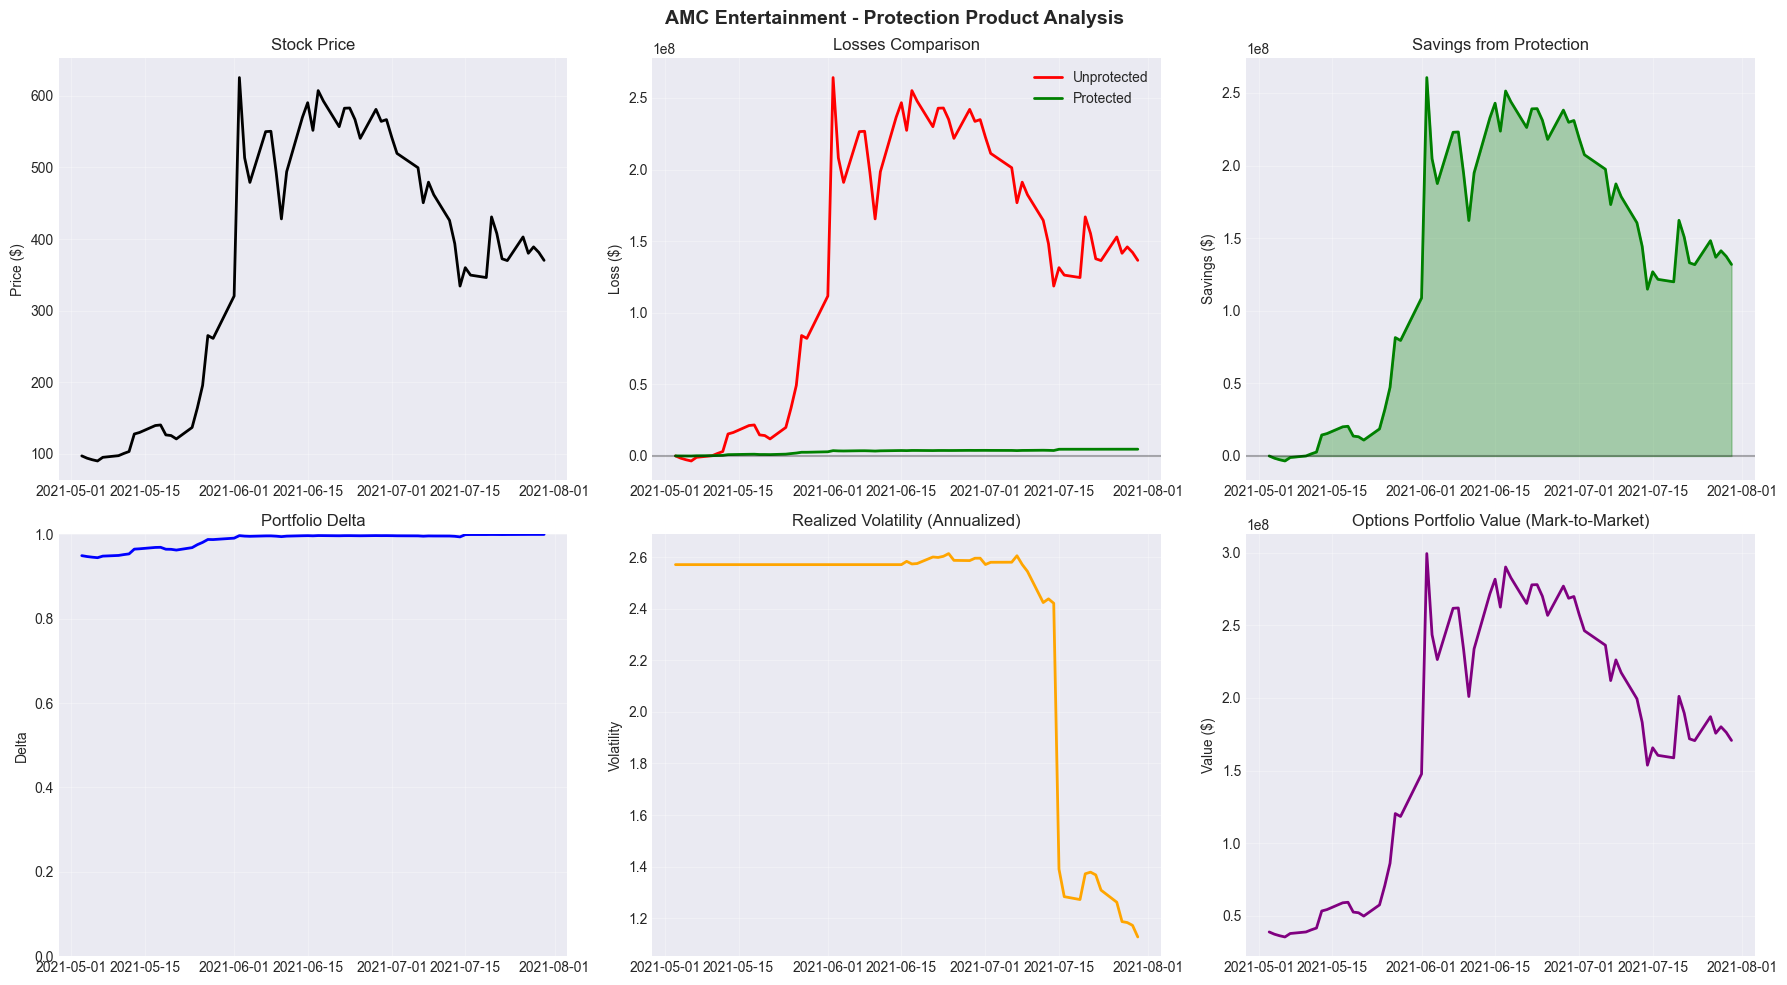

In [14]:
# Load data
amc_data = load_ticker_data('AMC')
amc_data['Volatility'] = calculate_volatility(amc_data, window=30)

# Setup
INITIAL_PRICE_AMC = amc_data['Close'].iloc[0]
NUM_SHARES_AMC = 500_000
AVG_VOL_AMC = amc_data['Volatility'].iloc[:10].mean()

# Create portfolio
amc_portfolio = create_options_portfolio(
    initial_price=INITIAL_PRICE_AMC,
    strikes=[15, 30, 50],
    maturities=[60, 120, 180],
    weights=[0.40, 0.35, 0.25],
    volatility=AVG_VOL_AMC
)

# Print cost breakdown
print_cost_breakdown(amc_portfolio, NUM_SHARES_AMC)

# Simulate with time-varying volatility
amc_results = simulate_protection(amc_data, amc_portfolio, NUM_SHARES_AMC, amc_data['Volatility'])

# Results
print_summary(amc_results, amc_portfolio, NUM_SHARES_AMC)
plot_results(amc_results, 'AMC Entertainment')

## Case Study 3: Comparison Across All Tickers

In [15]:
# Load metadata
metadata = load_metadata()

# Run analysis for all available tickers
comparison_results = []

for ticker in ['GME', 'AMC', 'TSLA', 'KOSS']:
    try:
        data = load_ticker_data(ticker)
        data['Volatility'] = calculate_volatility(data, window=30)
        
        initial_price = data['Close'].iloc[0]
        num_shares = 100_000
        avg_vol = data['Volatility'].iloc[:10].mean()
        
        portfolio = create_options_portfolio(
            initial_price=initial_price,
            strikes=[initial_price * 2, initial_price * 4, initial_price * 6],
            maturities=[90, 180, 270],
            weights=[0.35, 0.40, 0.25],
            volatility=avg_vol
        )
        
        # Use time-varying volatility in simulation
        results = simulate_protection(data, portfolio, num_shares, data['Volatility'])
        
        # Calculate total cost including fees
        notional = initial_price * num_shares
        options_premium = portfolio['total_price_per_share'] * num_shares
        total_cost = options_premium + (0.01 * notional) + (0.02 * notional)
        
        comparison_results.append({
            'Ticker': ticker,
            'Initial Price': initial_price,
            'Final Price': results['price'].iloc[-1],
            'Price Change %': (results['price'].iloc[-1] / initial_price - 1) * 100,
            'Max Unprotected Loss': results['unprotected_loss'].max(),
            'Max Protected Loss': results['protected_loss'].max(),
            'Total Savings': results['unprotected_loss'].max() - results['protected_loss'].max(),
            'Savings Rate %': (results['unprotected_loss'].max() - results['protected_loss'].max()) / results['unprotected_loss'].max() * 100,
            'Total Cost': total_cost,
            'Cost % of Notional': (total_cost / notional) * 100
        })
        
    except Exception as e:
        print(f"Skipping {ticker}: {e}")

comparison_df = pd.DataFrame(comparison_results)
print("\nComparison Across All Tickers:")
print(comparison_df.to_string(index=False))
comparison_df

Loaded GME: 60 days, Price range: $4.31 - $86.88
Loaded AMC: 63 days, Price range: $90.00 - $625.50
Loaded TSLA: 61 days, Price range: $24.08 - $61.16
Loaded KOSS: 60 days, Price range: $2.90 - $64.00

Comparison Across All Tickers:
Ticker  Initial Price  Final Price  Price Change %  Max Unprotected Loss  Max Protected Loss  Total Savings  Savings Rate %   Total Cost  Cost % of Notional
   GME       4.312500    48.615002     1027.304387          8.256500e+06        9.412417e+05   7.315259e+06       88.599992 3.897389e+05           90.374234
   AMC      97.099998   370.200012      281.256455          5.284000e+07        1.940790e+07   3.343210e+07       63.270444 3.862300e+06           39.776516
  TSLA      28.684000    33.475334       16.703856          3.247733e+06        2.610145e+06   6.375877e+05       19.631775 1.322338e+05            4.610019
  KOSS       3.190000    22.850000      616.300940          6.081000e+06        6.647671e+05   5.416233e+06       89.068128 3.054231e+05   

,Ticker,Initial Price,Final Price,Price Change %,Max Unprotected Loss,Max Protected Loss,Total Savings,Savings Rate %,Total Cost,Cost % of Notional
0,GME,4.312500,48.615002,1027.304387,8.256500e+06,9.412417e+05,7.315259e+06,88.599992,3.897389e+05,90.374234
1,AMC,97.099998,370.200012,281.256455,5.284000e+07,1.940790e+07,3.343210e+07,63.270444,3.862300e+06,39.776516
2,TSLA,28.684000,33.475334,16.703856,3.247733e+06,2.610145e+06,6.375877e+05,19.631775,1.322338e+05,4.610019
3,KOSS,3.190000,22.850000,616.300940,6.081000e+06,6.647671e+05,5.416233e+06,89.068128,3.054231e+05,95.743909
